In this notebook, we use a **simple momentum strategy** with equal **weight** for simplicity to test the hypothesis: The stocks that have high returns will continue to have high returns, while stocks that have low returns will continue to have low returns. We will test in 1, 3, 6, 12 months period using top 1000 US stocks data

In [1]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt

In [ ]:
# Read Data
file_path = r"C:\Users\ADMIN\Documents\CF_LeHoangPhuc-22110160_TranLongNhat-22110142\top_1000_stock_2015_2025.csv"
df = pd.read_csv(file_path, parse_dates=["date"])

# Kiểm tra cấu trúc dữ liệu 
print(df.head())
print(df.columns)

        date ticker       open       high        low      close  adj_close  \
0 2015-01-02   AAPL  27.847500  27.860001  26.837500  27.332500  24.261047   
1 2015-01-02   ABBV  65.440002  66.400002  65.440002  65.889999  42.091419   
2 2015-01-02    ABT  45.250000  45.450001  44.639999  44.900002  36.418671   
3 2015-01-02   ADBE  72.699997  73.199997  71.889999  72.339996  72.339996   
4 2015-01-02    ADI  55.680000  56.250000  54.970001  55.540001  44.511143   

        volume  
0  212818400.0  
1    5086100.0  
2    3216600.0  
3    2349200.0  
4    1323200.0  
Index(['date', 'ticker', 'open', 'high', 'low', 'close', 'adj_close',
       'volume'],
      dtype='object')


In [3]:
# resample to n_month-end prices
def resample_n_months(data, m):

    data = data.set_index("date")
    agg_dict = {
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "adj_close": "last",
        "volume": "sum"
    }

    data = (
         data.groupby("ticker")
        .resample(f"{m}ME")
        .agg(agg_dict)
        .reset_index()
    )
    return data

In [4]:
# Calculate n_monthly log-return
def calculate_log_return(data):
    data["log_return"] = (
        np.log(data["adj_close"]) - 
        np.log(data.groupby("ticker")["adj_close"].shift(1))
    )

    data = data.dropna(subset=["log_return"])
    data["lagged_return"] = data.groupby("ticker")["log_return"].shift(1)
    return data



In [5]:
# Simple Momentum Strategy

def generate_signals(data, n): # n is how many stocks to long/short
    data["rank"] = data.groupby("date")["lagged_return"].rank(method="first", ascending=False)
    data["position"] = 0
    data.loc[data["rank"] <= n, "position"] = 1
    data.loc[data["rank"] > data.groupby("date")["rank"].transform("max") - n, "position"] = -1
    return data


In [6]:
def backtest(data):
    data["weight"] = data.groupby(["date", "position"])["position"].transform(
        lambda x: 1 / len(x) if x.iloc[0] != 0 else 0
    )
    data["weighted_return"] = data["log_return"] * data["weight"]
    # Compute average return per side each month
    avg_returns = (
        data[data["position"] != 0]
        .groupby(["date", "position"])["log_return"]
        .mean()
        .unstack(fill_value=0)
    )
    # Compute long–short portfolio return
    avg_returns["portfolio_return"] = (avg_returns[1] - avg_returns[-1]) / 2

    #Cumulative performance
    avg_returns["cum_return"] = np.exp(avg_returns["portfolio_return"].cumsum())
    return avg_returns



C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6164\464658936.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["lagged_return"] = data.groupby("ticker")["log_return"].shift(1)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6164\464658936.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["lagged_return"] = data.groupby("ticker")["log_return"].shift(1)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6164\464658936.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

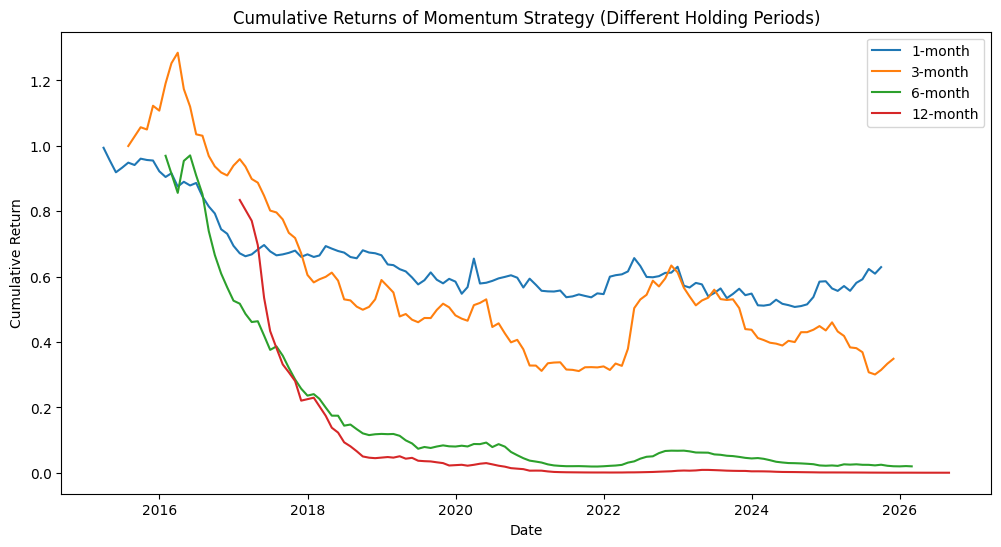

In [7]:
# --- Run for multiple holding periods ---
holding_periods = [1, 3, 6, 12]  # in months
n_stocks = 50  # number of stocks to long/short

plt.figure(figsize=(12, 6))

for m in holding_periods:
    # 1. Resample
    monthly_data = resample_n_months(df, m)
    
    # 2. Calculate log returns
    monthly_data = calculate_log_return(monthly_data)
    
    # 3. Generate signals
    monthly_data = generate_signals(monthly_data, n_stocks)
    
    # 4. Backtest
    result = backtest(monthly_data)
    
    # 5. Plot cumulative return
    plt.plot(result.index, result["cum_return"], label=f"{m}-month")

plt.title("Cumulative Returns of Momentum Strategy (Different Holding Periods)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [8]:
# Plot Result
def plot_result(data,n=1):
    data["cum_return"].plot(title="Long–Short Portfolio (Equal-Weighted)")
    plt.ylabel("Cumulative Return (exp of sum of log returns)")
    plt.show()